In [ ]:
from PIL import Image
from pathlib import Path
from fastai.basics import *
from fastai.text.all import *
from transformers import ReformerModelWithLMHead, ReformerTokenizerFast
from fastai.callback.wandb import *
import wandb

In [ ]:
wandb.init()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: marii (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

InvalidVersionSpec: Invalid version '2.3.0>=2.1.0': invalid character(s)



In [ ]:
#I forget why we do this, but needed to be done for dataloader, might be fastai bug? 
@patch
@delegates(TfmdDL.new)
def new(self:SortedDL, dataset=None, **kwargs):
    res = self.res if dataset is None else None
    
    return super(SortedDL, self).new(dataset=dataset, **merge({'res':res}, kwargs))

In [ ]:
axial=16
from transformers import ReformerConfig

#configuration = ReformerConfig(axial_pos_shape=(axial,axial),max_embedding_size=axial*axial,is_decoder=True)
tokenizer = ReformerTokenizerFast.from_pretrained('google/reformer-crime-and-punishment')

In [ ]:
model = ReformerModelWithLMHead.from_pretrained('google/reformer-crime-and-punishment') #(configuration)

Some weights of ReformerModelWithLMHead were not initialized from the model checkpoint at google/reformer-crime-and-punishment and are newly initialized: ['reformer.encoder.layers.0.attention.self_attention.mask_value_float16', 'reformer.encoder.layers.1.attention.self_attention.self_mask_value_float16', 'reformer.encoder.layers.0.attention.self_attention.mask_value_float32', 'reformer.encoder.layers.3.attention.self_attention.self_mask_value_float32', 'reformer.encoder.layers.1.attention.self_attention.mask_value_float16', 'reformer.encoder.layers.3.attention.self_attention.mask_value_float16', 'reformer.encoder.layers.2.attention.self_attention.mask_value_float32', 'reformer.encoder.layers.4.attention.self_attention.mask_value_float16', 'reformer.encoder.layers.1.attention.self_attention.mask_value_float32', 'reformer.encoder.layers.2.attention.self_attention.mask_value_float16', 'reformer.encoder.layers.5.attention.self_attention.self_mask_value_float16', 'reformer.encoder.layers.3.

Untrained model output: 

In [ ]:
path = untar_data(URLs.WIKITEXT_TINY)
df_train = pd.read_csv(path/'train.csv', header=None)
df_valid = pd.read_csv(path/'test.csv', header=None)

In [ ]:
all_texts = np.concatenate([df_train[0].values, df_valid[0].values])

In [ ]:
bs,sl = 1,524288 #axial*axial 

In [ ]:
def tokenize(text):
    toks = tokenizer.tokenize(text)
    return tensor(tokenizer.convert_tokens_to_ids(toks))

tokenized = [tokenize(t) for t in progress_bar(all_texts)]

In [ ]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        return x if isinstance(x, Tensor) else tokenize(x)
        
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [ ]:
class NoShortSequences(Callback):
    def __init__(self,seq_len):
        self.seq_len=seq_len
    def before_batch(self):
        if(self.xb[0].shape[1]<self.seq_len):
            raise CancelBatchException('seq_len too short')

In [ ]:
splits = [range_of(df_train), list(range(len(df_train), len(all_texts)))]
tls = TfmdLists(tokenized, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
dls = tls.dataloaders(bs=bs, seq_len=sl,drop_last=True)

Fine-tuning

In [ ]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [ ]:
learn = Learner(dls, model,opt_func=Lamb, loss_func=CrossEntropyLossFlat(), cbs=[GradientAccumulation(n_acc=4),DropOutput,NoShortSequences(sl),WandbCallback(log_preds=False)], metrics=Perplexity()).to_fp16()

In [ ]:
learn.validate()

WandbCallback requires use of "SaveModelCallback" to log best model


wandb: WARNING Step must only increase in log calls.  Step -1 < 0; dropping {'epoch': 0}.
wandb: WARNING Step must only increase in log calls.  Step -1 < 0; dropping {'valid_loss': 367.4601135253906, 'perplexity': '00:00'}.


(#2) [5.906614780426025,367.4601135253906]

In [ ]:
#learn.lr_find()

Probably need to write callback to skip the last batch. 

In [ ]:
#perplex (flat_cos) 9.698093
learn.fit_flat_cos(200, (1e-3))

epoch,train_loss,valid_loss,perplexity,time
0,6.022005,5.416744,225.144806,00:16
1,5.775645,4.894427,133.543442,00:16
2,5.539490,4.615515,101.039825,00:16
3,5.310256,4.185204,65.706909,00:16
4,5.067831,3.933807,51.101158,00:16
5,4.843029,3.683855,39.799538,00:16
6,4.634490,3.600391,36.612545,00:16
7,4.457669,3.563236,35.277153,00:16
8,4.313213,3.557439,35.073254,00:16
9,4.195694,3.497094,33.019371,00:16


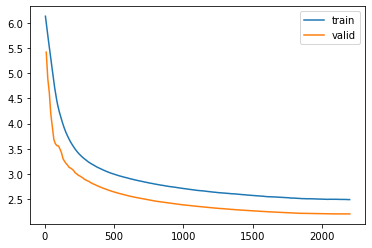

In [ ]:
#32.004402 fit_one_cycle lr=1e-4
learn.recorder.plot_loss()

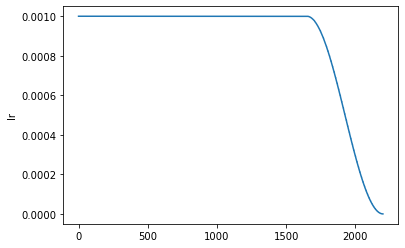

In [ ]:
learn.recorder.plot_sched()

In [ ]:
learn.show_results()

In [ ]:
f=lambda q:(0.1-(5-q)*(0.08+(5-q)*0.02))
f(0),f(5)

(-0.7999999999999999, 0.1)

In [ ]:
f=lambda q:(0.1-((5-q)*(0.18-q*0.02)))
f(0),f(5)

(-0.7999999999999999, 0.1)

In [ ]:
f=lambda q:(0.1-((0.18*5-(q*0.02*5)-(q*0.18)+0.02*q**2)))
f(0),f(5)

(-0.7999999999999999, 0.1)

In [ ]:
f=lambda q:(0.1-0.18*5+q*0.28-0.02*q**2)
f(0),f(5)

(-0.7999999999999999, 0.1000000000000002)

In [ ]:
f=lambda q:(-0.8+q*(0.28-0.02*q))
%timeit f(0),f(5)

355 ns ± 1.24 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


(-0.8, 0.09999999999999987)

In [ ]:
dls.train.get_idxs??

In [ ]:
dls.train.shuffle_fn

<bound method LMDataLoader.shuffle_fn of <fastai.text.data.LMDataLoader object at 0x7fd9d817b400>>

In [ ]:
len(dls.train)

11

Write Anki style sampler from dataset

In [ ]:
f=lambda q:(-0.8+q*(1.4-0.5*q))
f(0),f(1)

(-0.8, 0.09999999999999987)